# Stretch Response of Crayfish Muscle Receptor Organs
## Step 1: Format Recording
In this first section, we reformat the raw recording into a fiff file, thereby making it compatible with the mne-python package. This will come in handy for preprocessing and analysis.

The following is a table of recordings:

|Number|Retraction|Speed|Repeats|
|:----:|:--------:|:---:|:-----:|
| 000  | N/A      | N/A | N/A   |
| 001  | 0        | 0   | 0     |
| 002  | 1        | 1   | 10    |
| 003  | 2        | 1   | 10    |
| 004  | 3        | 1   | 10    |
| 005  | 2        | 2   | 1     |
| 006  | 2        | 1   | 1     |
| 007  | 2        | 3   | 1     |
| 008  | 2        | 2   | 1     |
| 009  | 2        | 2   | 1     |
| 010  | 2        | 4   | 1     |
| 011  | 2        | 5   | 1     |
| 012  | 2        | 6   | 1     |
| 013  | 3        | 1   | 1     |
| 014  | N/A      | N/A | N/A   |
| 015  | 3        | 2   | 1     |
| 016  | 3        | 3   | 1     |
| 017  | 3        | 4   | 1     |
| 018  | 3        | 5   | 1     |
| 019  | 3        | 6   | 1     |
| 020  | 3        | 1   | 1     |
| 021  | 3        | 3   | 1     |

**Notes:**
1. 2mm retraction is minimum needed to see slow-adapting MRO.
2. Physiological and/or chemical changes after 019 allowed recordings to reach steady state. 

In [1]:
import neo
import numpy as np
from mne import create_info
from mne.io import RawArray

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
file_dict = {'006':[2, 1], # retraction = 2, speed = 1
             '009':[2, 2], # retraction = 2, speed = 2
             '007':[2, 3], # retraction = 2, speed = 3
             '010':[2, 4], # retraction = 2, speed = 4
             '011':[2, 5], # retraction = 2, speed = 5
             '012':[2, 6], # retraction = 2, speed = 6
             '013':[3, 1], # retraction = 3, speed = 1
             '015':[3, 2], # retraction = 3, speed = 2
             '016':[3, 3], # retraction = 3, speed = 3
             '017':[3, 4], # retraction = 3, speed = 4
             '018':[3, 5], # retraction = 3, speed = 5
             '019':[3, 6]} # retraction = 3, speed = 6

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main body.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for k, v in file_dict.items():

    ## Load recordings.
    recordings, = neo.AxonIO(filename='raw/17o02%s.abf' %k).read_block().segments
    nerve, arduino = recordings.analogsignals

    ## Concatenate raw recordings.
    data = np.hstack([np.asarray(nerve, dtype=np.float64)  * 1e-6, # uV --> V 
                      np.asarray(arduino, dtype=np.float64)
                     ]).T

    ## Create info object.
    sfreq = float(nerve.sampling_rate)
    ch_names = ['nerve', 'arduino']
    ch_types = 'bio'

    info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

    ## Create Raw object.
    raw = RawArray(data, info)

    ## Save Raw object.
    raw.save('raw/stretch_r%ss%s_raw.fif' %(v[0], v[1]), overwrite=True, verbose=False)
    
print('Done.')

Creating RawArray with float64 data, n_channels=2, n_times=164864
    Range : 0 ... 164863 =      0.000 ...    16.486 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=178176
    Range : 0 ... 178175 =      0.000 ...    17.817 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=174592
    Range : 0 ... 174591 =      0.000 ...    17.459 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=156160
    Range : 0 ... 156159 =      0.000 ...    15.616 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=160256
    Range : 0 ... 160255 =      0.000 ...    16.026 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=195072
    Range : 0 ... 195071 =      0.000 ...    19.507 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=749568
    Range : 0 ... 749567 =      0.000 ...    74.957 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=199680
    Range : 0 ... 199679

## Step 2: Preprocess Recording
Next, we open the raw FIFF file and preform preprocessing. For this dataset, preprocessing will entail only filtering the data to remove slow-frequency drifts and high-frequency noise. [Gonzalo Rey et al. (2015)](http://www.sciencedirect.com/science/article/pii/S0361923015000684) recommend a high- and low-pass of 300 and 3000 Hz, respectively, for the extracellular nerve recording.


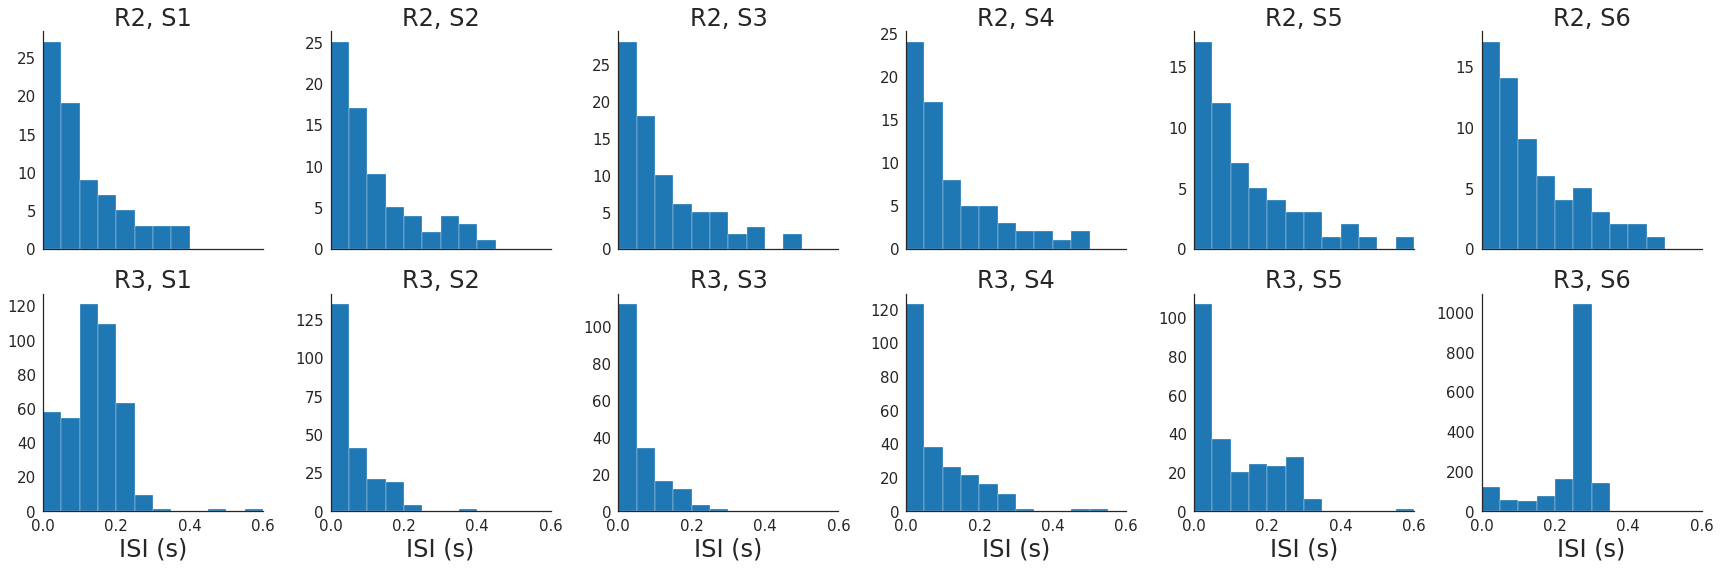

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, concat
from mne.io import Raw
from peak_detection import *
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
retractions = [2, 3]
speeds = np.arange(6) + 1

## Filter parameters (nerve).
bandpass = (300, 3000)

## Peak detection parameters.
threshold = 0.5e-3 # microvolts

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

data = []
for r in retractions:
    
    for s in speeds:

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Load and prepare data.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

        ## Load raw.
        f = 'raw/stretch_r%ss%s_raw.fif' %(r, s)
        raw = Raw(f, preload=True, verbose=False)

        ## Drop arduino recording.
        raw = raw.drop_channels(['arduino'])
        
        ## Filter data.
        raw = raw.filter(*bandpass, picks=[0], method='fir', phase='zero')

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Peak detection.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
        ## Extract extracellular nerve data.
        arr = raw.get_data().squeeze()
        times = raw.times.copy()
        
        ## Find peaks.
        peak_loc, peak_mag = peak_finder(arr, threshold)
        
        ## Identify and re-reference spike times.
        peak_times = times[peak_loc]
        times -= peak_times[0]
        peak_times -= peak_times[0]
        
        ## Compute difference between spike times.
        peak_diff = np.insert( np.diff(peak_times), 0, np.nan )
        
        ## Save as NumPy compressed file.
        np.savez_compressed('raw/stretch_r%ss%s' %(r, s), data=arr, times=times, peak_loc=peak_loc)
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Assemble into DataFrame.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
        ## Convert to DataFrame.
        df = DataFrame(np.vstack([peak_times, peak_mag, peak_diff]).T, columns=('Time', 'Voltage', 'Diff'))
       
        ## Store metadata.
        df['Retraction'] = r
        df['Speed'] = s
        
        ## Append.
        data.append(df)
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Concatenate DataFrame.
data = concat(data)

## Save data.
data.to_csv('stretch_response.csv', index=False)

## Plotting.
bins = np.arange(0,1+1e-6,0.05)
g = sns.FacetGrid(data, row='Retraction', col='Speed', sharey=False, size=4)
g.map(sns.distplot, 'Diff', bins=bins, kde=False, hist_kws=dict(edgecolor='w', alpha=1))

for i, r in enumerate(retractions):
    for j, s in enumerate(speeds):
        g.axes[i,j].set(xlim=(0.0,0.6))
        g.axes[i,j].set_title('R%s, S%s' %(r, s), fontsize=24)
        if i: g.axes[i,j].set_xlabel('ISI (s)', fontsize=24)
            
plt.tight_layout()

## Step 3: Fitting Exponential Models
In this section of code, two important operations are implemented:
1. **Firing rate calculation:** the adaptation of the MRO$_1$ firing rate over time estimated by binning action potentials, starting from the first spike, in 500ms windows.
2. **Exponential decay model:** exponential decay models are fitted to each MRO$_1$ firing rate timeseries (per retraction and speed). The curve fitted is of the form:
> $R_t = R_{\infty} + R_0e^{-t/\tau}$

where the firing rate at time $t$, $R_t$, is defined as the sum of the sustained firing rate, $R_{\infty}$, and the peak firing rate, $R_0$, multiplied by a decay function, where $\tau$ is the adaptation rate.

It is clear below that the peak firing rate, $R_0$, and adaptation rate, $\tau$, are functions of the retraction level. The relationship between speed and MRO$_1$ firing rate adaptation is less clear.

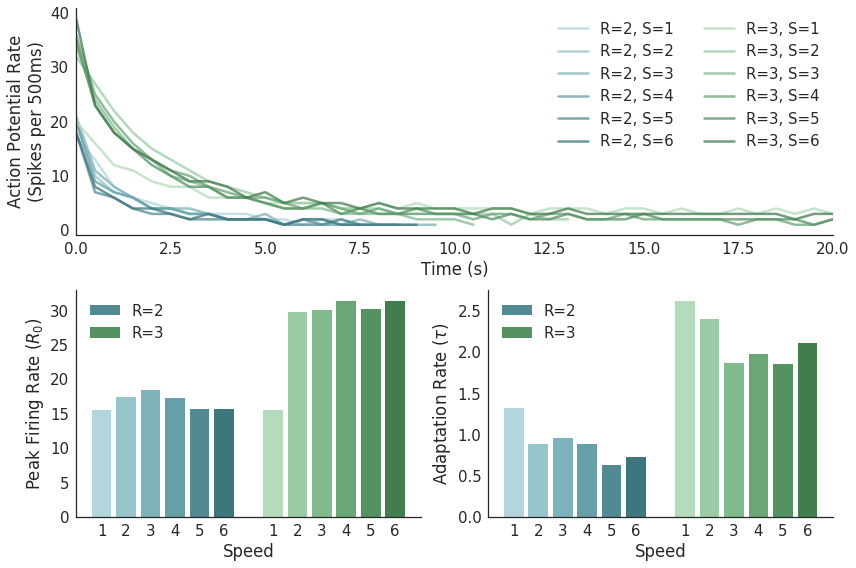

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mne.io import Raw
from pandas import DataFrame, read_csv, concat
from scipy.optimize import curve_fit
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
files = [(2,2), (3,2)]
retractions = [2, 3]
speeds = np.arange(6) + 1

## Curve-fitting parameters.
def exponential_curve(t, r_inf, r_0, tau):
    return r_inf + r_0 * np.exp(-t/tau)

w = 0.5 # bin width (seconds)
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
data = read_csv('stretch_response.csv')

## Preallocate space for parameters.
parameters = np.zeros((len(retractions), len(speeds), 3))

## Initialize canvas.
fig = plt.figure(figsize=(12,8))
ax = plt.subplot2grid((2,2),(0,0),colspan=2)
palettes = np.vstack([sns.cubehelix_palette(6, start=2.5, rot=0, dark=0.4, light=.8).as_hex(),
                      sns.cubehelix_palette(6, start=2, rot=0, dark=0.4, light=.8).as_hex()])

spike_rates = []
for i, colors in enumerate(palettes):
        
    for j, color in enumerate(colors):

        ## Extract data.
        r, s = retractions[i], speeds[j]
        arr = data.loc[np.logical_and(data.Retraction==r, data.Speed==s),'Time']
        
        ## Define bins and counts.
        bins = np.arange(0, w * (np.ceil(arr.max() / w) + 1), w)
        _, y = np.unique(np.digitize(arr, bins), return_counts=True)
        t = bins[:y.size]
        spike_rates.append( np.array([t,y,np.ones_like(t)*r,np.ones_like(t)*s]) )
        
        ## Fit curve.
        parameters[i,j,:], _ = curve_fit(exponential_curve, t, y, p0=[0, 50, 1])
        
        ## Plot.
        ax.plot(t, y, lw=2.5, alpha=0.75, color=color, label='R=%s, S=%s' %(r,s))
        
ax.set(xlim=(0,20), xlabel='Time (s)', ylabel='Action Potential Rate\n(Spikes per %0.0fms)' %(w*1e3))
ax.legend(ncol=2)

## Save spike rates.
spike_rates = DataFrame(np.concatenate(spike_rates, -1).T, columns=('Time', 'Rate', 'Retraction', 'Speed'))
spike_rates.to_csv('spike_rates.csv', index=False)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Reassemble parameters.
parameters = DataFrame(parameters.reshape(len(retractions)*len(speeds),3), 
                       columns=('Rinf', r'$R_0$', r'$\tau$'))
parameters['Retraction'] = np.repeat(retractions, len(speeds))
parameters['Speed'] = np.concatenate([speeds for _ in range(len(retractions))])
parameters.to_csv('exponential_curve.csv', index=False)

## Plotting.
x = np.concatenate([np.arange(6), np.arange(6)+7])
xticklabels = np.concatenate([np.arange(len(speeds)) for _ in range(len(retractions))]) + 1
ylabels = [r'Peak Firing Rate ($R_0$)', r'Adaptation Rate ($\tau$)']
colors = palettes.flatten()

for n, y in enumerate([r'$R_0$', r'$\tau$']):
    
    ## Barplots.
    ax = plt.subplot2grid((2,2),(1,n))
    ax.bar(x, parameters[y], color=colors)
    ax.set(xticks=x, xticklabels=xticklabels, xlabel='Speed', ylabel=ylabels[n])
    
    ## Legend.
    ax.bar(0, 0, label='R=2', color=colors[4])
    ax.bar(0, 0, label='R=3', color=colors[10])
    ax.legend(loc=0)

sns.despine()
plt.tight_layout()